In [1]:
# install VASA from test.pypi
pip install -i https://test.pypi.org/simple/VASA

In [ ]:
import pandas as pd
import geopandas as gpd
from VASA import VASA

In [3]:
# Read in USA counties geojson file
counties_map = gpd.read_file("../test data/counties.geojson") \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

# filter out states not in the continental US
counties_map = counties_map[[(state != '02' and state != '15' and int(state) < 60) for state in counties_map.STATEFP]]

counties_map.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,075,00277302,0500000US06075,06075,San Francisco,06,121485107,479107241,"POLYGON ((-2168086.764 33798.997, -2176962.349..."
1,25,025,00606939,0500000US25025,25025,Suffolk,06,150855462,160479920,"POLYGON ((1901690.921 519844.627, 1902812.906 ..."
2,31,007,00835826,0500000US31007,31007,Banner,06,1932676697,397069,"POLYGON ((-629496.462 227201.747, -576250.975 ..."
3,37,181,01008591,0500000US37181,37181,Vance,06,653705784,42187365,"POLYGON ((1476930.940 -269973.669, 1488024.098..."
4,48,421,01383996,0500000US48421,48421,Sherman,06,2390651189,428754,"POLYGON ((-521740.024 -394881.325, -510740.158..."


In [4]:
# read in the Safegraph data file:
data = pd.read_csv("../test data/counties.csv")

# We need to ensure that these GEOID's match the ones in our GeoDataFrame - add leading zeros
data.fips = [f"{d:05}" for d in data.fips]

data.head()

,fips,ds_m4,sg_avg_dist2
0,45035,2020-01-01,11066.255084
1,45035,2020-01-02,13048.934918
2,45035,2020-01-03,13383.727687
3,45035,2020-01-04,11845.334563
4,45035,2020-01-05,9796.491319


In [5]:
# Load data into a VASA object
v = VASA(
    df=data,
    gdf=counties_map,
    group_summary=lambda g: g[:2], # state level
    df_group_col="fips",
    gdf_group_col="GEOID",
    date_col="ds_m4",
    temp_res="week",               # get weekly average values
    date_format="%Y-%m-%d"
).group() # perform the weekly aggration

In [ ]:
# Loko at the percentage of missing values for each data column
v.pct_full_missing()

In [ ]:
# Since there are missing values, fill them in with the weekly averages
v.fill_missing()

In [ ]:
# Construct a spatial weights matrix as a union between Queens and K-nearest neighbors with k=3
# and show the matrix on a plot of the US
v.show_weights_connection(k=3, type="union")

![](counties_weights_connections.png)

In [ ]:
# Perform LISA classification for each week using the specified spatial weights matrix:
v.lisa(k=3, type="union")

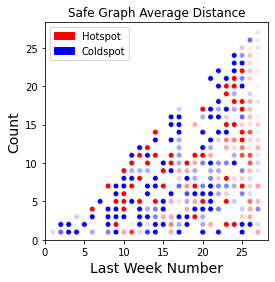

In [11]:
from VASA.scatter import Scatter
sc = Scatter(v, titles=["Safe Graph Average Distance"])

sc.plot()

The scatter plot above shows a circle for each county, at the location of the total number of significant hot or cold spots (count) and the last week there was a significant hot or cold spot. If multiple counties end up at the same location on the chart, the color is red if a majority of the counties were hotspots (a darker red means higher proportion) or blue if the majority of the counties were coldspots.

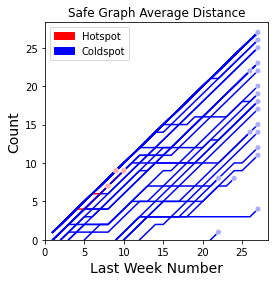

In [13]:
sc.plot(highlight="06")  # highlight counties in California (fips code = 06)

The scatter plot above shows the trajectories of counties in California of the cumulative number of significant hotspots or coldspots and the weeks these occured at. 

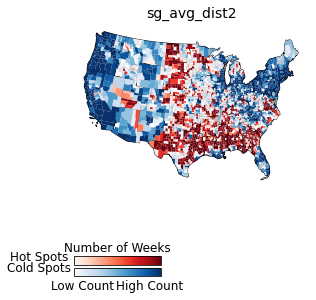

In [14]:
from VASA.static_choropleth import StackedChoropleth

stacked = StackedChoropleth(v, os.getcwd() + "/imgs/counties")
stacked.plot_count()

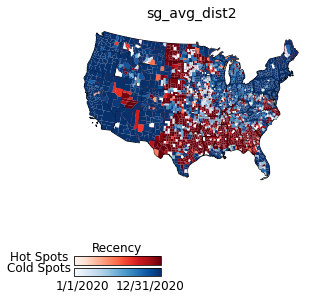

In [15]:
stacked.plot_recent()

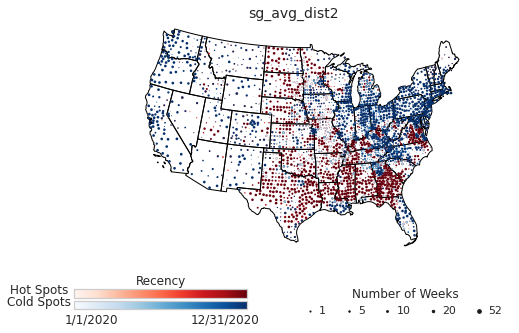

In [21]:
stacked = StackedChoropleth(v, "")
stacked.plot_both(a=2500, b=600, show=True) # specify the a (intercept) and b (slope) to control the sizing of points on the map

The map above combines the previous two choropleths to show both the number of times a county was classified as a hotspot or coldspot (count) and the last week of this classification (recency)

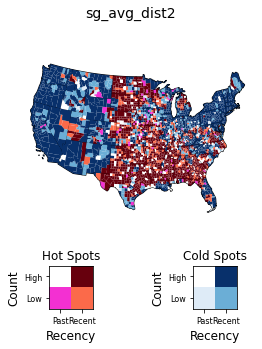

In [17]:
stacked.plot_bivar(show=True)

The map above also shows count and recency of significant hotspots and coldspots, binned into the first or second half of weeks in recency and binned into less than or more than half of the number of weeks in count. The upper left quadrant is missing, since counties cannot be classified as a hot or cold spot more times than there are weeks available for such classification.

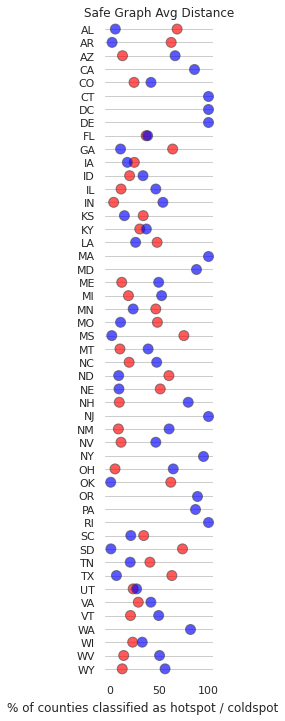

In [18]:
from VASA.stripplot import Strip

s = Strip(v, titles="Safe Graph Avg Distance")
s.plot(show=True)

This stripplot shows for each state, the percentage of counties where it's most often classification (hotspot, coldspot or not significant) over the time period were hotspots or coldspots. 